# RNN Modeling of Weight Data

## Setup

In [1]:
from wlp_utils import ml_utils

import importlib
import datetime

%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from ggplot import *

Using TensorFlow backend.
/Users/jamieinfinity/.local/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/jamieinfinity/.local/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


In [172]:
importlib.reload(ml_utils)

<module 'wlp_utils.ml_utils' from '/Users/jamieinfinity/Projects/WorldLine/worldline-wgt/server/src/wlp_utils/ml_utils.py'>

## Data

In [2]:
this=ml_utils.get_model_data_df('2015-09-16', '2020-01-01')
this.tail(5)

,Weight,Steps,Calories
Date,,,
2017-09-06,168.8,19121.0,2954.0
2017-09-07,169.6,14247.0,1915.0
2017-09-08,168.1,22544.0,2236.0
2017-09-09,168.0,20040.0,2677.0
2017-09-10,168.5,15730.0,2665.0


In [3]:
x_train, y_train, dates = ml_utils.get_model_data_seq('2015-09-16', '2015-09-30', 10, shuffle=False)

In [3]:
WGT_SCALE_FACTOR = 50
NUM_FEATURES = 3
SEQUENCE_LENGTH = 30
TEST_DAYS = 100
HOLDOUT_DAYS = 3
NFOLDS = 5

[(features_train, target_train, dates_train), (features_test, target_test, dates_test), (features_holdout, target_holdout, dates_holdout)] = ml_utils.get_model_data_splits(
    sequence_length=SEQUENCE_LENGTH, 
    holdout_days=HOLDOUT_DAYS, 
    test_days=TEST_DAYS
)

In [4]:
len(features_train)

593

## Model Building

### Parameters

In [5]:
model_params = {
    'num_features':NUM_FEATURES,
    'sequence_length':SEQUENCE_LENGTH,
    'lstm_sizes':[256],
    'lstm_dropout_rates':[0.1]
}
# model_params = {
#     'num_features':NUM_FEATURES,
#     'sequence_length':SEQUENCE_LENGTH,
#     'lstm_sizes':[64, 32, 16],
#     'lstm_dropout_rates':[0.15, 0.1, 0.05]
# }
training_params = {
    'verboseness':0,
    'loss_function':'mean_absolute_error',
    'optimization_method':'adam',
    'batch_size':10,
    'epochs':1000,
    'early_stopping_patience':5,
    'min_delta':0.001
}

### Train CV models

In [51]:
importlib.reload(ml_utils)

<module 'wlp_utils.ml_utils' from '/Users/jamieinfinity/Projects/WorldLine/worldline-wgt/server/src/wlp_utils/ml_utils.py'>

In [73]:
results = ml_utils.train_cv_models(model_params,
                          training_params,
                          [(features_train, target_train), (features_test, target_test)],
                          n_splits=NFOLDS,
                          random_state=1, 
                          early_stopping_data=(features_test, target_test)
                         )

Fold 0 
losses - train: 0.019044, val: 0.019077, test: 0.021784
Fold 1 
losses - train: 0.017984, val: 0.018037, test: 0.020534
Fold 2 
losses - train: 0.017609, val: 0.017196, test: 0.019970
Fold 3 
losses - train: 0.017374, val: 0.017287, test: 0.019851
Fold 4 
losses - train: 0.017880, val: 0.018374, test: 0.020629


In [74]:
models = results['models']
histories = results['histories']
losses = results['losses']
cv_indices = results['cv_indices']

In [75]:
[x.epoch[-1] for x in histories]

[13, 13, 14, 18, 15]

In [76]:
np.array([x['test'] for x in results['losses']]).mean()*WGT_SCALE_FACTOR

1.0276825327268788

### Train bootstrapped models

In [153]:
importlib.reload(ml_utils)

<module 'wlp_utils.ml_utils' from '/Users/jamieinfinity/Projects/WorldLine/worldline-wgt/server/src/wlp_utils/ml_utils.py'>

In [207]:
results = ml_utils.train_bs_models(model_params,
                          training_params,
                          [(features_train, target_train), (features_test, target_test)],
                          n_samples=2,
                          sample_size=300
                         )

Sample 0 
losses - train: 0.019938, test: 0.022941
Sample 1 
losses - train: 0.017636, test: 0.020887


In [208]:
models = results['models']
histories = results['histories']
losses = results['losses']
bs_indices = results['bs_indices']

In [209]:
[x.epoch[-1] for x in histories]

[14, 20]

In [210]:
np.array([x['test'] for x in results['losses']]).mean()*WGT_SCALE_FACTOR

1.0956956618006379

## Errors Over Sequence of Days

In [159]:
errors_samples = []
abs_errors_samples = []
indices = bs_indices # cv_indices
for index in range(len(models)): 
    train_index = indices[index]
    # X, y = features_train[train_index], target_train[train_index]
    X, y = features_test, target_test
    errors = np.array([0 for i in range(0,len(X[0]))])
    abs_errors = np.array([0 for i in range(0,len(X[0]))])
    model = models[index]
    for i in range(0, len(X)):
        x_in = np.array([X[i]])
        pred = model.predict(x_in)[0]
        true = y[i]
        errors = errors + (pred-true).reshape(len(X[0]))
        abs_errors = abs_errors + np.abs(pred-true).reshape(len(X[0]))
    errors = WGT_SCALE_FACTOR*errors/len(X)
    abs_errors = WGT_SCALE_FACTOR*abs_errors/len(X)
    errors_samples.append(errors)
    abs_errors_samples.append(abs_errors)

In [160]:
[x[-1] for x in errors_samples]

[0.2152061593690705,
 -0.38130041945246085,
 0.10591611109891215,
 -0.31261372680492999,
 -0.15459524440191355,
 -0.42168617614655612,
 -0.27867901859246702,
 -0.68548105498532363,
 -0.062579587615008342,
 -0.33579907313296686]

In [156]:
np.mean([x[-1] for x in errors_samples])

-0.2311612030663644

In [157]:
np.mean([x[-1] for x in abs_errors_samples])

0.98439213417000493

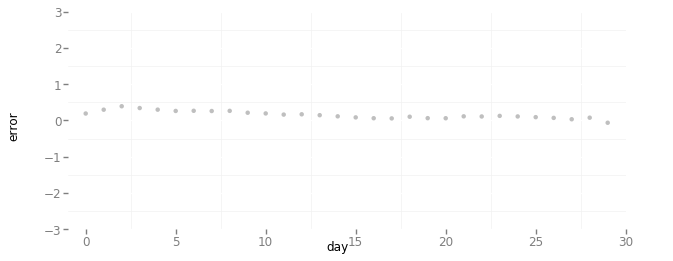

In [158]:
errs = errors_samples[8]
errors_df = pd.DataFrame({'day':range(0,len(X[0])), 'error':errs})

p = ggplot(aes(x='day', y='error'), data=errors_df) +\
geom_point(color='black', alpha=0.25)  +\
scale_x_continuous(limits=(-1, 30)) +\
scale_y_continuous(limits=(-3, 3)) +\
theme_bw()

p.save('test.png', width=10, height=4)

## Errors Over Data Set

### Training set

In [211]:
weight_target = [ml_utils.weight_inverse_transform(x[0]) for x in target_train[:,-1]]
dates_target = [x + np.timedelta64(1, 'D') for x in dates_train[:,-1]]
weight_target_df = pd.DataFrame({'date': dates_target, 'weight': weight_target})

(dates_target_min, dates_target_max) = (dates_target[0]-np.timedelta64(5,'D'), dates_target[-1]+np.timedelta64(5,'D'))

weight_pred_folds = []
for fold in range(len(models)):
    model = models[fold]
    weight_pred = [model.predict(np.array([x]))[0][-1][0] for x in features_train]
    weight_pred = [ml_utils.weight_inverse_transform(x) for x in weight_pred]
    weight_pred_folds.append(weight_pred)
    
weight_pred_folds = np.array(weight_pred_folds).transpose()
weight_pred_mean = weight_pred_folds.mean(axis=1)
weight_pred_std = weight_pred_folds.std(axis=1)
weight_pred_min = weight_pred_mean - weight_pred_std
weight_pred_max = weight_pred_mean + weight_pred_std
weight_pred_df = pd.DataFrame({'date':dates_target, 'weight':weight_pred_mean, 'wmin':weight_pred_min, 'wmax':weight_pred_max})

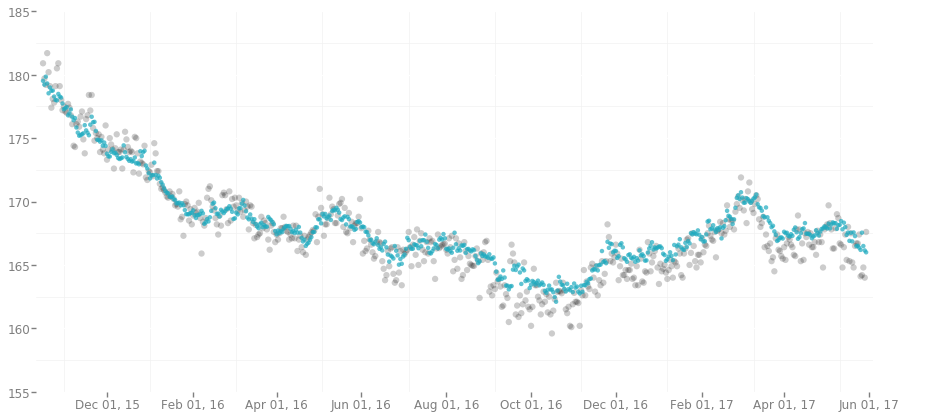

In [214]:
p = ggplot(aes(x='date', y='weight'), data=weight_target_df) +\
geom_point(color='black', alpha=0.2, size=40) +\
geom_point(data=weight_pred_df, color='#1DAABF', alpha=0.7, size=20) +\
scale_y_continuous(limits=(155, 185)) +\
scale_x_date(labels = date_format("%b %d, %y"), breaks = date_breaks('month'), limits=(dates_target_min, dates_target_max)) +\
xlab(element_text(size=12, text=' ')) +\
ylab(element_text(size=12, text=' ')) +\
theme_bw()

p.save('test.png', width=15, height=7)

#geom_ribbon(aes(x='date', ymin='wmin', ymax='wmax'), fill='#1DAABF', alpha=0.5, data=weight_pred_df) +\


### Test set

In [215]:
weight_target = [ml_utils.weight_inverse_transform(x[0]) for x in target_test[:,-1]]
dates_target = [x + np.timedelta64(1, 'D') for x in dates_test[:,-1]]
days_target = list(range(len(dates_target)))
weight_target_df = pd.DataFrame({'day':days_target, 'date': dates_target, 'weight': weight_target})

(dates_target_min, dates_target_max) = (dates_target[0]-np.timedelta64(5,'D'), dates_target[-1]+np.timedelta64(5,'D'))

weight_pred_folds = []
for fold in range(len(models)):
    model = models[fold]
    weight_pred = [model.predict(np.array([x]))[0][-1][0] for x in features_test]
    weight_pred = [ml_utils.weight_inverse_transform(x) for x in weight_pred]
    weight_pred_folds.append(weight_pred)
    
weight_pred_folds = np.array(weight_pred_folds).transpose()
weight_pred_mean = weight_pred_folds.mean(axis=1)
weight_pred_std = weight_pred_folds.std(axis=1)
weight_pred_min = weight_pred_mean - weight_pred_std
weight_pred_max = weight_pred_mean + weight_pred_std
weight_pred_df = pd.DataFrame({'day':days_target, 'date':dates_target, 'weight':weight_pred_mean, 'wmin':weight_pred_min, 'wmax':weight_pred_max})

In [216]:
weight_pred_mean

array([ 166.23535007,  166.25105739,  166.39412642,  167.02440307,
        167.36617014,  167.15151742,  167.56337956,  167.62286946,
        167.51177981,  167.66980365,  167.75369272,  168.13361719,
        167.66756102,  167.31778309,  167.24495664,  167.38890037,
        167.85061285,  169.00298074,  168.65761057,  167.96528473,
        167.77856275,  167.81552508,  167.65672192,  167.92862415,
        168.55271235,  168.80895123,  168.22018102,  168.09861436,
        168.11635718,  168.07337925,  168.38415042,  168.76954213,
        169.01062503,  169.14124265,  169.12267283,  168.7867038 ,
        168.99268702,  169.94943246,  169.88156587,  169.81666833,
        169.00716498,  168.78929064,  168.60806495,  168.53994653,
        168.93606558,  168.70569065,  168.86536255,  168.29158142,
        168.80654022,  168.35877523,  169.35413256,  168.7130712 ,
        169.31195632,  169.39781606,  169.75819096,  169.87087205,
        169.48057637,  169.07384917,  170.34888864,  170.50527

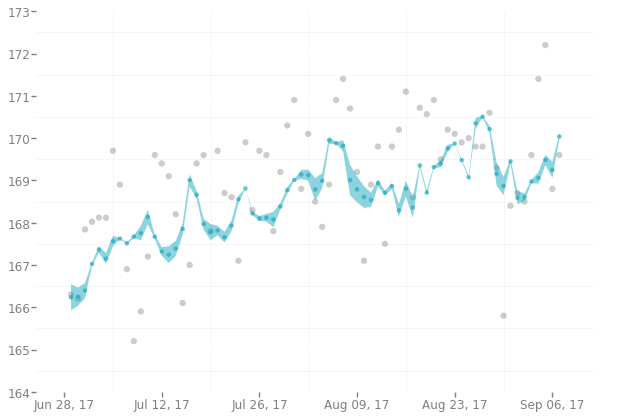

In [217]:
p = ggplot(aes(x='date', y='weight'), data=weight_target_df) +\
geom_point(color='black', alpha=0.2, size=40) +\
geom_point(data=weight_pred_df, color='#1DAABF', alpha=0.7, size=20) +\
geom_ribbon(aes(x='date', ymin='wmin', ymax='wmax'), fill='#1DAABF', alpha=0.5, data=weight_pred_df) +\
scale_y_continuous(limits=(164, 173)) +\
scale_x_date(labels = date_format("%b %d, %y"), breaks = date_breaks('month'), limits=(dates_target_min, dates_target_max)) +\
xlab(element_text(size=12, text=' ')) +\
ylab(element_text(size=12, text=' ')) +\
theme_bw()

p.save('test.png', width=10, height=7)

## Forecasted Predictions

### Training set

In [175]:
weight_target = [ml_utils.weight_inverse_transform(x[0]) for x in target_train[:,-1]]
dates_target = [x + np.timedelta64(1, 'D') for x in dates_train[:,-1]]
weight_target_df = pd.DataFrame({'date': dates_target, 'weight': weight_target})

(dates_target_min, dates_target_max) = (dates_target[0]-np.timedelta64(5,'D'), dates_target[-1]+np.timedelta64(5,'D'))

In [176]:
weight_pred_folds = []
for fold in range(len(models)):
    model = models[fold]
    rolling_sequence = features_train[0]
    weight_pred = []
    for t in range(1, len(dates_target)):
        pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
        weight_pred.append(pred)
        features_next = features_train[t][-1]
        features_next[0] = pred
        rolling_sequence = features_test[t][0:(SEQUENCE_LENGTH-1)]
        rolling_sequence = np.append(rolling_sequence, np.array([features_next]), axis=0)
    final_pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
    weight_pred.append(final_pred)
    weight_pred = [ml_utils.weight_inverse_transform(x) for x in weight_pred]
    weight_pred_folds.append(weight_pred)

weight_pred_folds = np.array(weight_pred_folds).transpose()
weight_pred_mean = weight_pred_folds.mean(axis=1)
weight_pred_std = weight_pred_folds.std(axis=1)
weight_pred_min = weight_pred_mean - weight_pred_std
weight_pred_max = weight_pred_mean + weight_pred_std
weight_pred_df = pd.DataFrame({'date':dates_target, 'weight':weight_pred_mean, 'wmin':weight_pred_min, 'wmax':weight_pred_max})

/Users/jamieinfinity/.local/lib/python3.5/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


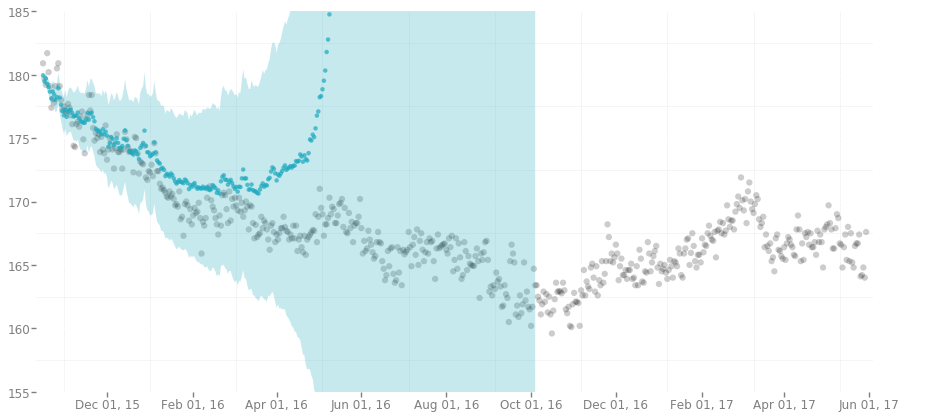

In [177]:
p = ggplot(aes(x='date', y='weight'), data=weight_target_df) +\
geom_point(color='black', alpha=0.2, size=40) +\
geom_point(data=weight_pred_df, color='#1DAABF', alpha=0.7, size=20) +\
geom_ribbon(aes(x='date', ymin='wmin', ymax='wmax'), fill='#1DAABF', alpha=0.25, data=weight_pred_df) +\
scale_y_continuous(limits=(155, 185)) +\
scale_x_date(labels = date_format("%b %d, %y"), breaks = date_breaks('month'), limits=(dates_target_min, dates_target_max)) +\
xlab(element_text(size=12, text=' ')) +\
ylab(element_text(size=12, text=' ')) +\
theme_bw()

p.save('test.png', width=15, height=7)

In [178]:
weight_pred_mean = []
weight_pred_std = []
rolling_sequence = features_train[0]
for t in range(1, len(dates_target)):
    weight_pred_folds = np.array([])
    for fold in range(len(models)):
        model = models[fold]
        pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
        weight_pred_folds = np.append(weight_pred_folds, pred)
    weight_mean = np.mean(weight_pred_folds)
    weight_std = np.std([ml_utils.weight_inverse_transform(x) for x in weight_pred_folds])
    weight_pred_mean.append(ml_utils.weight_inverse_transform(weight_mean))
    weight_pred_std.append(weight_std)
    features_next = features_train[t][-1]
    features_next[0] = weight_mean
    rolling_sequence = features_test[t][0:(SEQUENCE_LENGTH-1)]
    rolling_sequence = np.append(rolling_sequence, np.array([features_next]), axis=0)

weight_pred_folds = np.array([])    
for fold in range(len(models)):
    model = models[fold]
    pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
    weight_pred_folds = np.append(weight_pred_folds, pred)
weight_mean = np.mean(weight_pred_folds)
weight_std = np.std([ml_utils.weight_inverse_transform(x) for x in weight_pred_folds])
weight_pred_mean.append(ml_utils.weight_inverse_transform(weight_mean))
weight_pred_std.append(weight_std)
weight_pred_mean = np.array(weight_pred_mean)
weight_pred_std = np.array(weight_pred_std)
weight_pred_min = weight_pred_mean - weight_pred_std
weight_pred_max = weight_pred_mean + weight_pred_std
weight_pred_df = pd.DataFrame({'date':dates_target, 'weight':weight_pred_mean, 'wmin':weight_pred_min, 'wmax':weight_pred_max})

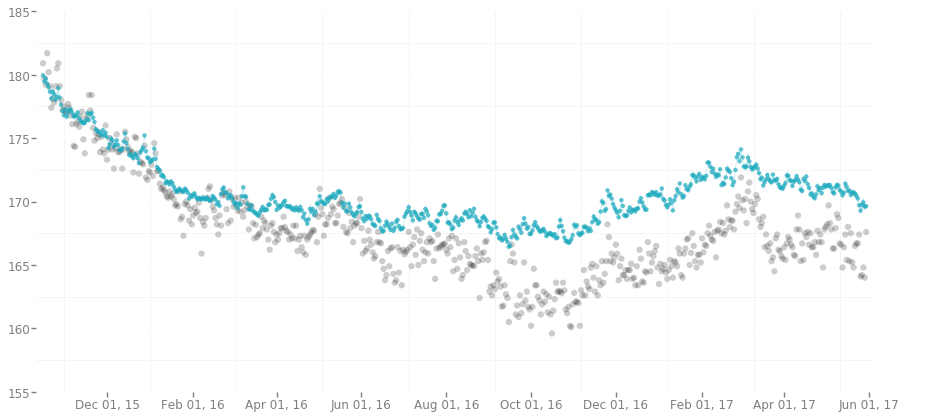

In [179]:
p = ggplot(aes(x='date', y='weight'), data=weight_target_df) +\
geom_point(color='black', alpha=0.2, size=40) +\
geom_point(data=weight_pred_df, color='#1DAABF', alpha=0.7, size=20) +\
geom_ribbon(aes(x='date', ymin='wmin', ymax='wmax'), fill='#1DAABF', alpha=0.25, data=weight_pred_df) +\
scale_y_continuous(limits=(155, 185)) +\
scale_x_date(labels = date_format("%b %d, %y"), breaks = date_breaks('month'), limits=(dates_target_min, dates_target_max)) +\
xlab(element_text(size=12, text=' ')) +\
ylab(element_text(size=12, text=' ')) +\
theme_bw()

p.save('test.png', width=15, height=7)

### Test set

In [218]:
weight_target = [ml_utils.weight_inverse_transform(x[0]) for x in target_test[:,-1]]
dates_target = [x + np.timedelta64(1, 'D') for x in dates_test[:,-1]]
days_target = list(range(len(dates_target)))
weight_target_df = pd.DataFrame({'day':days_target, 'date': dates_target, 'weight': weight_target})

(dates_target_min, dates_target_max) = (dates_target[0]-np.timedelta64(5,'D'), dates_target[-1]+np.timedelta64(5,'D'))

In [219]:
weight_pred_folds = []
for fold in range(len(models)):
    model = models[fold]
    rolling_sequence = features_test[0]
    weight_pred = []
    for t in range(1, len(dates_target)):
        pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
        weight_pred.append(pred)
        features_next = features_test[t][-1]
        features_next[0] = pred
        rolling_sequence = features_test[t][0:(SEQUENCE_LENGTH-1)]
        rolling_sequence = np.append(rolling_sequence, np.array([features_next]), axis=0)
    final_pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
    weight_pred.append(final_pred)
    weight_pred = [ml_utils.weight_inverse_transform(x) for x in weight_pred]
    weight_pred_folds.append(weight_pred)

weight_pred_folds = np.array(weight_pred_folds).transpose()
weight_pred_mean = weight_pred_folds.mean(axis=1)
weight_pred_std = weight_pred_folds.std(axis=1)
weight_pred_min = weight_pred_mean - weight_pred_std
weight_pred_max = weight_pred_mean + weight_pred_std
weight_pred_df = pd.DataFrame({'day':days_target, 'date':dates_target, 'weight':weight_pred_mean, 'wmin':weight_pred_min, 'wmax':weight_pred_max})

In [220]:
weight_pred_mean

array([ 166.23535007,  166.0958983 ,  166.33663848,  166.98306575,
        167.35246778,  167.08011627,  167.47037247,  167.51273051,
        167.45116264,  167.59951636,  167.70165935,  168.11748818,
        167.60750934,  167.10772067,  167.06332937,  167.20740944,
        167.74202362,  168.93527731,  168.69007647,  167.88844243,
        167.56604388,  167.61836335,  167.55819395,  167.82215461,
        168.44136491,  168.71573254,  168.13041046,  168.01471412,
        167.98009276,  167.92292222,  168.2067126 ,  168.69666427,
        168.98778155,  169.02289242,  168.9475961 ,  168.66454855,
        168.81611571,  169.87103969,  169.94213983,  169.6954377 ,
        168.7942937 ,  168.53021756,  168.49252358,  168.50230545,
        168.94559339,  168.68103817,  168.78847107,  168.17499325,
        168.63029152,  168.20101067,  169.21020448,  168.72426793,
        169.22446862,  169.35186014,  169.61036697,  169.75080445,
        169.39823702,  168.98548305,  170.26778683,  170.50640

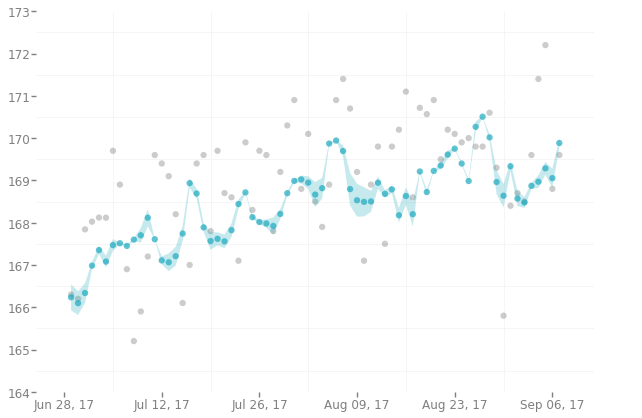

In [221]:
p = ggplot(aes(x='date', y='weight'), data=weight_target_df) +\
geom_point(color='black', alpha=0.2, size=40) +\
geom_point(data=weight_pred_df, color='#1DAABF', alpha=0.7, size=40) +\
geom_ribbon(aes(x='date', ymin='wmin', ymax='wmax'), fill='#1DAABF', alpha=0.25, data=weight_pred_df) +\
scale_y_continuous(limits=(164, 173)) +\
scale_x_date(labels = date_format("%b %d, %y"), breaks = date_breaks('month'), limits=(dates_target_min, dates_target_max)) +\
xlab(element_text(size=12, text=' ')) +\
ylab(element_text(size=12, text=' ')) +\
theme_bw()

p.save('test.png', width=10, height=7)

In [222]:
weight_pred_mean = []
weight_pred_std = []
rolling_sequence = features_test[0]
for t in range(1, len(dates_target)):
    weight_pred_folds = np.array([])
    for fold in range(len(models)):
        model = models[fold]
        pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
        weight_pred_folds = np.append(weight_pred_folds, pred)
    weight_mean = np.mean(weight_pred_folds)
    weight_std = np.std([ml_utils.weight_inverse_transform(x) for x in weight_pred_folds])
    weight_pred_mean.append(ml_utils.weight_inverse_transform(weight_mean))
    weight_pred_std.append(weight_std)
    features_next = features_test[t][-1]
    features_next[0] = weight_mean
    rolling_sequence = features_test[t][0:(SEQUENCE_LENGTH-1)]
    rolling_sequence = np.append(rolling_sequence, np.array([features_next]), axis=0)

weight_pred_folds = np.array([])    
for fold in range(len(models)):
    model = models[fold]
    pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
    weight_pred_folds = np.append(weight_pred_folds, pred)
weight_mean = np.mean(weight_pred_folds)
weight_std = np.std([ml_utils.weight_inverse_transform(x) for x in weight_pred_folds])
weight_pred_mean.append(ml_utils.weight_inverse_transform(weight_mean))
weight_pred_std.append(weight_std)
weight_pred_mean = np.array(weight_pred_mean)
weight_pred_std = np.array(weight_pred_std)
weight_pred_min = weight_pred_mean - weight_pred_std
weight_pred_max = weight_pred_mean + weight_pred_std
weight_pred_df = pd.DataFrame({'date':dates_target, 'weight':weight_pred_mean, 'wmin':weight_pred_min, 'wmax':weight_pred_max})

In [223]:
weight_pred_mean

array([ 166.23535007,  166.09444246,  166.32727683,  166.97544381,
        167.34804437,  167.07812846,  167.46516228,  167.51107201,
        167.45069847,  167.59929359,  167.70156845,  168.11668947,
        167.60967001,  167.1081841 ,  167.0620136 ,  167.20579937,
        167.73460284,  168.93425658,  168.68913248,  167.88989231,
        167.56564155,  167.61700585,  167.55699292,  167.82116517,
        168.43629405,  168.71389225,  168.12987104,  168.01479682,
        167.97990426,  167.92242154,  168.20573732,  168.69657561,
        168.98795664,  169.02311817,  168.94752309,  168.66399571,
        168.81468743,  169.87108439,  169.94209439,  169.69540715,
        168.79335344,  168.52843687,  168.49056706,  168.50006059,
        168.93878207,  168.67926493,  168.78755614,  168.17435101,
        168.62571463,  168.19895506,  169.20854896,  168.72381195,
        169.22411025,  169.35180575,  169.61017773,  169.75044385,
        169.39808056,  168.98529306,  170.26691809,  170.50675

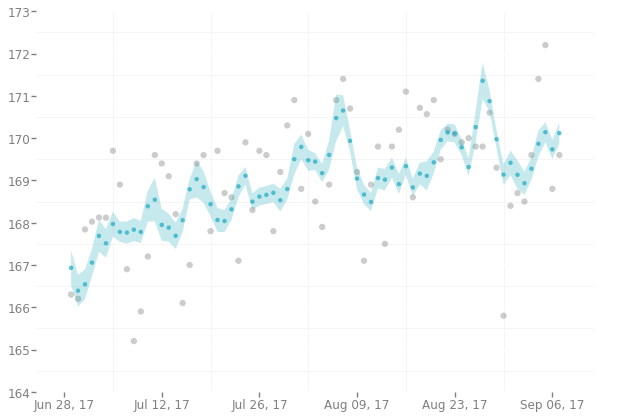

In [195]:
p = ggplot(aes(x='date', y='weight'), data=weight_target_df) +\
geom_point(color='black', alpha=0.2, size=40) +\
geom_point(data=weight_pred_df, color='#1DAABF', alpha=0.7, size=20) +\
geom_ribbon(aes(x='date', ymin='wmin', ymax='wmax'), fill='#1DAABF', alpha=0.25, data=weight_pred_df) +\
scale_y_continuous(limits=(164, 173)) +\
scale_x_date(labels = date_format("%b %d, %y"), breaks = date_breaks('month'), limits=(dates_target_min, dates_target_max)) +\
xlab(element_text(size=12, text=' ')) +\
ylab(element_text(size=12, text=' ')) +\
theme_bw()

p.save('test.png', width=10, height=7)